In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import uproot
import modplot
from pathlib import Path

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers

# Optional: quieter logs
os.environ.setdefault("TF_CPP_MIN_LOG_LEVEL", "1")

2026-02-20 15:35:58.957164: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-20 15:35:59.158799: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-02-20 15:35:59.158907: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-02-20 15:35:59.167240: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-02-20 15:35:59.208122: I tensorflow/core/platform/cpu_feature_guar

'1'

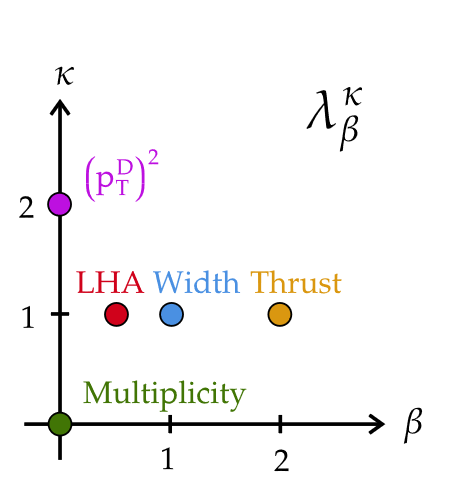

# Config


In [ ]:
centralityBins = (0, 10)  # (min, max) in %
# centralityBins=(10,40) # corresponds to 1 bin
# centralityBins=(40,80) # corresponds to 2 bin

nEventsExp=224032

SIM_TO_EXP_RATIO = 10
nEvents = SIM_TO_EXP_RATIO * nEventsExp

isClosureTest = False

features = [ 'pt', 'z', 'eta', 'dispersion', 'lambda1_0_5', 'lambda1_1', 'lambda1_1_5', 'lambda1_2', 'lambda1_3']

tag = ''
iterations = 4
dropout_rate = 0.05

base = Path("closureTest" if isClosureTest else "realData")
saveFolder = base / f"centrality{centralityBins[0]}_{centralityBins[1]}" / tag
saveFolder.mkdir(parents=True, exist_ok=True)


Processing centrality bin:  (centralityAlt >= 0) & (centralityAlt < 10)


### Setup embedding tree


In [ ]:
embedding_tree= uproot.open("~/dev/star/Omnifold/Omnifold/Simulation_04022026.root")["jets"]
selected_branches_embedding =[
'centrality',
 'centralityAlt',
 'weightCentrality',
 'gRefMult',
 'mcD0Pt',
 'mcSmearedD0Pt',
 'mcSmearedD0Eta',
 'mcJetPt',
 'mcJetEta',
 'mcJetLambda1_0_5',
 'mcJetLambda1_1',
 'mcJetLambda1_1_5',
 'mcJetLambda1_2',
 'mcJetLambda1_3',
 'mcJetMomDisp',
 'mcJetD0Z',
 'mcSmearedJetEta',
 'recoJetPt',
 'recoJetPtCorr',
 'recoJetRho',
 'recoJetEta',
 'recoJetArea',
 'recoJetNConst',
 'recoJetLambda1_0_5',
 'recoJetLambda1_1',
 'recoJetLambda1_1_5',
 'recoJetLambda1_2',
 'recoJetLambda1_3',
 'recoJetMomDisp',
 'recoJetD0Z',
 'ICS_recoJetPt',
 'ICS_recoJetRho',
 'ICS_recoJetEta',
 'ICS_recoJetArea',
 'ICS_recoJetNConst',
 'ICS_recoJetLambda1_0_5',
 'ICS_recoJetLambda1_1',
 'ICS_recoJetLambda1_1_5',
 'ICS_recoJetLambda1_2',
 'ICS_recoJetLambda1_3',
 'ICS_recoJetMomDisp',
 'ICS_recoJetD0Z']


mapCentrality = {0:70, 1:60, 2:50, 3:40, 4:30, 5:20, 6:10, 7:5, 8:0}

embedding_tree = uproot.open("~/dev/star/Omnifold/Omnifold/Simulation_04022026.root")["jets"]
sim_mc_reco = embedding_tree.arrays(selected_branches_embedding, library="pd", entry_stop=nEvents)

# Fast vectorized mapping
sim_mc_reco["centralityAlt"] = sim_mc_reco["centrality"].map(mapCentrality).fillna(-1).astype("int16")
sim_mc_reco.drop(columns=["centrality"], inplace=True)

# Filter centrality
cmin, cmax = centralityBins
sim_mc_reco = sim_mc_reco[(sim_mc_reco["centralityAlt"] >= cmin) & (sim_mc_reco["centralityAlt"] < cmax)]

# Weight
sim_mc_reco["weight"] = sim_mc_reco["weightCentrality"].astype("float32")

### Setup real data tree


In [ ]:
# exp_tree= uproot.open("Omnifold/RealDataWsWeights_04022026.root")["jets"]
exp_tree= uproot.open("~/dev/star/Omnifold/Omnifold/ICS_RealDataWsWeights_04022026.root")["jets"]

selected_branches_exp = [
 'centrality',
 'jetPt',
 'jetEta',
 'jetPhi',
 'jetArea',
 'jetD0DeltaR',
 'nJetConst',
 'lambda1_0_5',
 'lambda1_1',
 'lambda1_1_5',
 'lambda1_2',
 'lambda1_3',
 'momDisp',
 'z',
 'weightCentrality',
 'weightD0Efficiency',
 'weightDoubleCount',
 'sWeightSignal'
 ]
    
    
exp = exp_tree.arrays(selected_branches_exp, library="pd", entry_stop=nEvents)

exp["centralityAlt"] = exp["centrality"].map(mapCentrality).fillna(-1).astype("int16")

cmin, cmax = centralityBins
exp = exp[(exp["centralityAlt"] >= cmin) & (exp["centralityAlt"] < cmax)]

# Signed sWeight is kept
exp["weight_signed"] = (
    exp["weightCentrality"]
    * exp["weightD0Efficiency"]
    * exp["weightDoubleCount"]
    * exp["sWeightSignal"]
).astype("float32")

# rename columns - remove "jet" 
exp.rename(columns={
    'jetPt': 'pt',
    'jetEta': 'eta',
    'jetArea': 'area',
    'nJetConst': 'nconst',
    'momDisp' : 'dispersion',
    'jetD0DeltaR': 'd0DeltaR',
    'z': 'z',
}, inplace=True)

exp.drop(columns=["centrality", "weightCentrality", "weightD0Efficiency",
                  "weightDoubleCount", "sWeightSignal"], inplace=True)

In [ ]:
# apply feature scaling on pt. pt = log pt

# # and add lower bound to avoid negative values for RecoJetPt
# min_pt = min(sim_mc_reco['RecoJetPt'].min(), exp['pt'].min())
# sim_mc_reco['RecoJetPt'] = np.log(sim_mc_reco['RecoJetPt']-min_pt+1)
# # now exp
# exp['pt'] = np.log(exp['pt']-min_pt+1)

genMcFeatures = ['weight','mcJetPt', 'mcJetEta', 'mcJetD0Z', 'mcJetLambda1_0_5', 
                 'mcJetLambda1_1', 'mcJetLambda1_1_5','mcJetLambda1_2','mcJetLambda1_3', 'mcJetMomDisp', 
                #  'mcJetArea', 
                #  'mcJetNConst', 
                #  'mcJetD0DeltaR'
                ]

recoMcFeatures = ['weight','ICS_recoJetPt', 'ICS_recoJetEta', 'ICS_recoJetD0Z',  'ICS_recoJetLambda1_0_5',
                  'ICS_recoJetLambda1_1', 'ICS_recoJetLambda1_1_5', 'ICS_recoJetLambda1_2', 'ICS_recoJetLambda1_3', 'ICS_recoJetMomDisp', 
                  # 'recoJetArea', 
                  # 'recoJetNConst', 
                  # 'recoJetD0DeltaR'
                  ]
gen_rename = {
    'mcJetPt': 'pt', 'mcJetD0Z': 'z', 'mcJetEta': 'eta', 'mcJetMomDisp': 'dispersion',
    'mcJetLambda1_0_5': 'lambda1_0_5', 'mcJetLambda1_1': 'lambda1_1',
    'mcJetLambda1_1_5': 'lambda1_1_5', 'mcJetLambda1_2': 'lambda1_2', 'mcJetLambda1_3': 'lambda1_3',
}
reco_rename = {
    'ICS_recoJetPt': 'pt', 'ICS_recoJetD0Z': 'z', 'ICS_recoJetEta': 'eta', 'ICS_recoJetMomDisp': 'dispersion',
    'ICS_recoJetLambda1_0_5': 'lambda1_0_5', 'ICS_recoJetLambda1_1': 'lambda1_1',
    'ICS_recoJetLambda1_1_5': 'lambda1_1_5', 'ICS_recoJetLambda1_2': 'lambda1_2', 'ICS_recoJetLambda1_3': 'lambda1_3',
}

genMcJets  = sim_mc_reco[genMcFeatures].rename(columns=gen_rename)
recoMcJets = sim_mc_reco[recoMcFeatures].rename(columns=reco_rename)


assert genMcJets.shape == recoMcJets.shape

if isClosureTest:
    from sklearn.model_selection import train_test_split
    trainGen, testGen, trainReco, testReco = train_test_split(genMcJets, recoMcJets, test_size=0.2)
else:
    trainGen, trainReco = genMcJets, recoMcJets
    testReco = exp
    testGen = None  # important: don’t accidentally treat this as "truth"

In [6]:
corr = trainGen.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(color='#f1f1f1')  # Color NaNs grey
 .format(precision=3))

,weight,pt,eta,z,lambda1_0_5,lambda1_1,lambda1_1_5,lambda1_2,lambda1_3,dispersion
weight,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
pt,0.002,nan,nan,nan,nan,nan,nan,nan,nan,nan
eta,-0.000,-0.002,nan,nan,nan,nan,nan,nan,nan,nan
z,-0.001,-0.390,0.005,nan,nan,nan,nan,nan,nan,nan
lambda1_0_5,0.001,0.334,-0.006,-0.877,nan,nan,nan,nan,nan,nan
lambda1_1,0.000,0.269,-0.005,-0.860,0.963,nan,nan,nan,nan,nan
lambda1_1_5,0.000,0.228,-0.005,-0.807,0.908,0.985,nan,nan,nan,nan
lambda1_2,0.000,0.195,-0.005,-0.743,0.853,0.951,0.989,nan,nan,nan
lambda1_3,0.000,0.131,-0.005,-0.605,0.736,0.852,0.919,0.964,nan,nan
dispersion,-0.001,-0.421,0.006,0.978,-0.899,-0.866,-0.807,-0.744,-0.611,nan


## Unfold Data

In [ ]:
# ---- Build numpy feature matrices once (faster + avoids repeated DataFrame slicing) ----
X_trainReco = trainReco[features].to_numpy(dtype=np.float32, copy=False)
X_testReco  = testReco[features].to_numpy(dtype=np.float32, copy=False)
X_trainGen  = trainGen[features].to_numpy(dtype=np.float32, copy=False)

# Detector-level classifier input: (Sim reco) vs (Data reco)
X_det = np.vstack([X_trainReco, X_testReco])
Y_det = np.concatenate([
    np.zeros(len(X_trainReco), dtype=np.float32),
    np.ones(len(X_testReco),  dtype=np.float32)
])

# Truth-level classifier input: (Gen) vs (Reweighted Gen)
X_gen = np.vstack([X_trainGen, X_trainGen])
Y_gen = np.concatenate([
    np.zeros(len(X_trainGen), dtype=np.float32),
    np.ones(len(X_trainGen),  dtype=np.float32)
])

# Push/pull weights storage: shape = (#iteration, #step, #event)
weights = np.empty((iterations, 2, len(X_trainReco)), dtype=np.float32)

# Normalizer
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(X_det)

def build_model():
    inp = tf.keras.Input(shape=(len(features),))
    x = normalizer(inp)
    x = layers.Dense(100, activation="relu")(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(100, activation="relu")(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(100, activation="relu")(x)
    x = layers.Dropout(dropout_rate)(x)
    out = layers.Dense(1, activation="sigmoid")(x)
    return tf.keras.Model(inp, out)

earlystopping = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
    verbose=1
)

2026-02-20 15:05:57.523794: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2026-02-20 15:05:57.968745: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2026-02-20 15:05:57.968825: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2026-02-20 15:05:57.976093: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2026-02-20 15:05:57.976197: I external/local_xla/xla/stream_executor

In [ ]:
print("X_det:", X_det.shape, "Y_det:", Y_det.shape)
print("X_gen:", X_gen.shape, "Y_gen:", Y_gen.shape)
print("ratio of data to sim:", len(X_testReco) / len(X_trainReco))

X_det:  (436170, 9)
Y_det:  (436170,)
X_gen:  (718902, 9)
Y_gen:  (718902,)
(359451, 9) (76719, 9)
ratio of exp to sim:  0.2134338199086941


In [ ]:
trainWts = np.ones(len(trainGen), dtype=np.float32)
print("Sum of training weights: ", trainWts.sum())

testWts = testReco["weight"]
testWts = testWts/testWts.mean()
print("Sum of testing weights: ", testWts.sum())


ndata, nsim = np.count_nonzero(Y_det), np.count_nonzero(Y_det==0)
if isClosureTest:
  testWts = np.ones(ndata)
  
sumTrainWts = trainWts.sum()
sumTestWts = testWts.sum()
trainWts= (sumTestWts/sumTrainWts)*trainWts

#  reweight the sim and data to have the same total weight to begin with
print ("ndata = ", ndata)
print ("nsim = ", nsim)

# # Push and pull weights in unfolding
# # initial iterative weights are the nominal weight
weights_pull = trainWts
weights_push = trainWts
w_data = testWts

print(np.sum(testWts), np.sum(trainWts))

Sum of training weights:  359451.0
Sum of testing weights:  76719.0
ndata =  76719
nsim =  359451
76719.0 76719.0


In [10]:
# ---- OmniFold training loop (optimized: fewer conversions/copies, consistent float32) ----

def reweight(events):
    """Return per-event density-ratio weights from the current classifier."""
    events = np.asarray(events, dtype=np.float32)
    f = model.predict(events, batch_size=5*2000, verbose=0)
    f = np.clip(f, 1e-6, 1.0 - 1e-6)
    w = f / (1.0 - f)
    return np.squeeze(np.nan_to_num(w, posinf=1.0, neginf=0.0, nan=1.0))

# Make sure weights are numpy float32 (pandas Series -> ndarray once)
trainWts = np.asarray(trainWts, dtype=np.float32)
w_data   = np.asarray(w_data,   dtype=np.float32)

weights_push = np.asarray(weights_push, dtype=np.float32)

# Reuse the same model object, but reset weights before each fit (OmniFold typically trains fresh each step)
initial_weights = model.get_weights()
rng = np.random.default_rng(42)

for it in range(iterations):
    print(f"\nITERATION: {it + 1}\n")

    # ---------------- STEP 1: reco-level (Sim reco -> Data reco) ----------------
    print("STEP 1\n")
    weights_det = np.concatenate([weights_push, w_data]).astype(np.float32)

    idx = rng.permutation(len(X_det))
    split = int(0.8 * len(idx))
    tr, te = idx[:split], idx[split:]

    model.set_weights(initial_weights)
    model.compile(
        loss='binary_crossentropy',
        optimizer='Adam',
        metrics=['accuracy'],
        weighted_metrics=[]
    )

    model.fit(
        X_det[tr], Y_det[tr],
        sample_weight=weights_det[tr],
        epochs=200,
        batch_size=5*2000,
        validation_data=(X_det[te], Y_det[te], weights_det[te]),
        callbacks=[earlystopping],
        verbose=1
    )

    weights_pull = weights_push * reweight(X_trainReco)
    weights[it, 0, :] = weights_pull

    # ---------------- STEP 2: truth-level (Gen -> reweighted Gen) ----------------
    print("\nSTEP 2\n")
    weights_model = np.concatenate([trainWts, weights_pull]).astype(np.float32)

    idx = rng.permutation(len(X_gen))
    split = int(0.8 * len(idx))
    tr, te = idx[:split], idx[split:]

    model.set_weights(initial_weights)
    model.compile(
        loss='binary_crossentropy',
        optimizer='Adam',
        metrics=['accuracy'],
        weighted_metrics=[]
    )

    model.fit(
        X_gen[tr], Y_gen[tr],
        sample_weight=weights_model[tr],
        epochs=200,
        batch_size=5*2000,
        validation_data=(X_gen[te], Y_gen[te], weights_model[te]),
        callbacks=[earlystopping],
        verbose=1
    )

    weights_push = reweight(X_trainGen)
    weights[it, 1, :] = weights_push



ITERATION: 1

STEP 1

Epoch 1/200


2026-02-20 15:06:26.933298: I external/local_xla/xla/service/service.cc:168] XLA service 0x7798864b9670 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-02-20 15:06:26.933356: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2026-02-20 15:06:26.975967: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-02-20 15:06:27.061733: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
I0000 00:00:1771596387.214749  362764 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


35/35 [==============================] - 4s 20ms/step - loss: 0.2319 - accuracy: 0.5776 - val_loss: 0.2239 - val_accuracy: 0.6275
Epoch 2/200
35/35 [==============================] - 0s 11ms/step - loss: 0.2181 - accuracy: 0.5880 - val_loss: 0.2196 - val_accuracy: 0.5644
Epoch 3/200
35/35 [==============================] - 0s 12ms/step - loss: 0.2151 - accuracy: 0.5824 - val_loss: 0.2190 - val_accuracy: 0.5363
Epoch 4/200
35/35 [==============================] - 0s 13ms/step - loss: 0.2149 - accuracy: 0.5794 - val_loss: 0.2191 - val_accuracy: 0.5364
Epoch 5/200
35/35 [==============================] - 0s 11ms/step - loss: 0.2142 - accuracy: 0.5752 - val_loss: 0.2175 - val_accuracy: 0.5729
Epoch 6/200
35/35 [==============================] - 0s 13ms/step - loss: 0.2132 - accuracy: 0.5774 - val_loss: 0.2169 - val_accuracy: 0.5780
Epoch 7/200
35/35 [==============================] - 0s 12ms/step - loss: 0.2132 - accuracy: 0.5829 - val_loss: 0.2169 - val_accuracy: 0.5557
Epoch 8/200
35/35 

In [11]:
# import omnifold_new as of
# import importlib
# importlib.reload(of)

# weights = of.omnifold(trainGen[features], trainReco[features], testReco[features], trainWts, testWts, iterations, model,1)

In [12]:
np.save(f"{saveFolder}/weights.npy", weights)

In [13]:
plt.rcParams['figure.figsize'] = (6,6)
plt.rcParams['figure.dpi'] = 240
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": "Helvetica",
})
# a dictionary to hold information about the observables
obs = {}
# the jet mass and histogram style information
obs.setdefault('pt', {}).update({
    'nbins_det': 20, 'nbins_mc': 20,
    'xlim': (1, 40), 
    'ylim': (1e-7, 1),
    'xlim_det': (1, 40),
    'xlabel': r'Jet $p_{t}$  [GeV/c]', 'symbol': r'$p_{t}$',
    'ylabel': r'Counts', 'yscale': 'log',
    'stamp_xy': (0.2, 0.25),
    'legend_loc': 'upper right'
})

# the groomed momentum fraction and histogram style information
obs.setdefault('z', {}).update({
    'nbins_det': 20, 'nbins_mc': 20,
    'xlim': (0.1, 1.001), 
    'ylim': (1e-4, 10),
    'xlim_det': (0.1, 1.001),
    'xlabel': r'Jet Momentum Fraction $z$', 'symbol': r'$z$',
    'ylabel': r'Counts',
    'stamp_xy': (0.425, 0.65),
})

obs.setdefault('lambda1_1', {}).update({
    'nbins_det': 20, 'nbins_mc': 20,
    'xlim': (0, 0.65), 
    'xlim_det': (0, 0.65),   
    'xlabel': r'Jet Angularity $\lambda_{1}^{1}$', 'symbol': r'$lambda1_1$',
    'ylabel': r'Counts',
    'stamp_xy': (0.1, 0.65),
})

obs.setdefault('lambda1_1_5', {}).update({
    'nbins_det': 20, 'nbins_mc': 20,
    'xlim': (0, 0.35),
    'xlim_det': (0, 0.35),  
    'xlabel': r'Jet Angularity $\lambda_{1}^{1/2}$', 'symbol': r'$lambda1_1_5$',
    'ylabel': r'Counts',
    'stamp_xy': (0.1, 0.65),
})

obs.setdefault('lambda1_2', {}).update({
    'nbins_det': 20, 'nbins_mc': 20,
    'xlim': (0, 0.15), 
    'xlim_det': (0, 0.15),  
    'xlabel': r'Jet Angularity $\lambda_{1}^{2}$', 'symbol': r'$lambda1_2$',
    'ylabel': r'Counts',
    'stamp_xy': (0.1, 0.65),
})

obs.setdefault('lambda1_3', {}).update({
    'nbins_det': 20, 'nbins_mc': 20,
    'xlim': (0, 0.055), 
    'xlim_det': ( 0, 0.055),  
    'xlabel': r'Jet Angularity $\lambda_{1}^{3}$', 'symbol': r'$lambda1_3$',
    'ylabel': r'Counts',
    'stamp_xy': (0.1, 0.65),
})

obs.setdefault('eta', {}).update({
    'nbins_det': 20, 'nbins_mc': 20,
    'xlim': (-0.6, 0.6),
    'xlim_det': (-0.6, 0.6),  
    'xlabel': r'Jet  $\eta$', 'symbol': r'$\eta$',
    'ylabel': r'Counts',
    'stamp_xy': (0.425, 0.65),
})

obs.setdefault('dispersion', {}).update({
    'nbins_det': 20, 'nbins_mc': 20,
    'xlim': (0.3, 1), 
    'xlim_det': ( 0.3, 1),
    'xlabel': r'Jet Dispersion', 'symbol': r'$dispersion$',
    'ylabel': r'Counts',
    'stamp_xy': (0.1, 0.65),
})

# obs.setdefault('area', {}).update({
#     'nbins_det': 20, 'nbins_mc': 20,
#     'xlim': (0, 1), 
#     'xlim_det': (0, 1),  
#     'xlabel': r'Jet Area', 'symbol': r'$area$',
#     'ylabel': r'Counts',
#     'stamp_xy': (0.1, 0.65),
# })

# obs.setdefault('nconst', {}).update({
#     'nbins_det': 20, 'nbins_mc': 20,
#     'xlim': (0, 100), 
#     'xlim_det': (0, 200),  
#     'xlabel': r'Jet Constituents', 'symbol': r'$nconst$',
#     'ylabel': r'Counts',
#     'stamp_xy': (0.1, 0.65),
# })

# obs.setdefault('d0DeltaR', {}).update({
#     'nbins_det': 20, 'nbins_mc': 20,
#     'xlim': (0, 0.5), 
#     'xlim_det': (0, 0.5),  
#     'xlabel': r'Jet $D_{0}\Delta R$', 'symbol': r'$d0DeltaR$',
#     'ylabel': r'Counts',
#     'stamp_xy': (0.1, 0.65),
# })



# additional histogram and plot style information
hist_style = {'histtype': 'step', 'lw': 1, 'zorder': 2}
gen_style = {'linestyle': '-', 'color': 'blue', 'lw': 1.15, 'label': 'Gen.'}
truth_style = {'step': 'mid', 'edgecolor': 'green', 'facecolor': (0.75, 0.875, 0.75),
               'lw': 1.25, 'zorder': 0, 'label': '``Truth\"'}
omnifold_style = {'ls': 'none', 'marker': 's', 'ms': 2.5, 'zorder': 3}
ibu_style = {'ls': '-', 'marker': 'o', 'ms': 2.5, 'color': 'gray', 'zorder': 1}

plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': False
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': False
}

plot_style_2 = {'alpha': 0.5, 'density': False}



for obkey,ob in obs.items():
        # calculate observable for GEN, SIM, DATA
    ob['genobs'] = trainGen[obkey].to_numpy()
    ob['simobs'] = trainReco[obkey].to_numpy()

    ob['truthobs'] = testGen[obkey].to_numpy()
    ob['dataobs'] = testReco[obkey].to_numpy()

 # setup bins if they are not present
    if 'bins_det' not in ob:
        ob['bins_det'] = np.linspace(ob['xlim_det'][0], ob['xlim_det'][1], ob['nbins_det']+1)
    if 'bins_mc' not in ob:
        ob['bins_mc'] = np.linspace(ob['xlim'][0], ob['xlim'][1], ob['nbins_mc']+1)
    
    ob['bins_det'] = np.array(ob['bins_det'])
    ob['bins_mc'] = np.array(ob['bins_mc'])

    # calculate midpoints of the bins 
    ob['midbins_det'] = 0.5*(ob['bins_det'][1:] + ob['bins_det'][:-1])
    ob['midbins_mc'] = 0.5*(ob['bins_mc'][1:] + ob['bins_mc'][:-1])

    # calculate widths of the bins
    ob['binwidth_det'] = ob['bins_det'][1:] - ob['bins_det'][:-1]
    ob['binwidth_mc'] = ob['bins_mc'][1:] - ob['bins_mc'][:-1]


    # get the histograms of GEN, DATA, and SIM level observables
    ob['genobs_hist'] = np.histogram(ob['genobs'], bins=ob['bins_mc'])[0]
    ob['simobs_hist'] = np.histogram(ob['simobs'], bins=ob['bins_det'])[0]
    ob['data_hist']   = np.histogram(ob['dataobs'], bins=ob['bins_det'])[0]
    ob['truth_hist'], ob['truth_hist_unc'] = modplot.calc_hist(ob['truthobs'], bins=ob['bins_mc'], 
                                                               density=False)[:2]

    # # compute (and normalize) the response matrix between GEN and SIM
    # ob['response'] = np.histogram2d(ob['simobs'], ob['genobs'], bins=(ob['bins_det'], ob['bins_mc']))[0]
    # ob['response'] /= (ob['response'].sum(axis=0) + 10**-50)
    
    # # perform iterative Bayesian unfolding
    # ob['ibu_phis'] = ibu.ibu(ob['data_hist'], ob['response'], ob['genobs_hist'], 
    #                      ob['binwidth_det'], ob['binwidth_mc'], it=iterations)
    # ob['ibu_phi_unc'] = ibu.ibu_unc(ob, it=iterations, nresamples=25)

    print('Done with', obkey)
    

Done with pt
Done with z
Done with lambda1_1
Done with lambda1_1_5
Done with lambda1_2
Done with lambda1_3
Done with eta
Done with dispersion


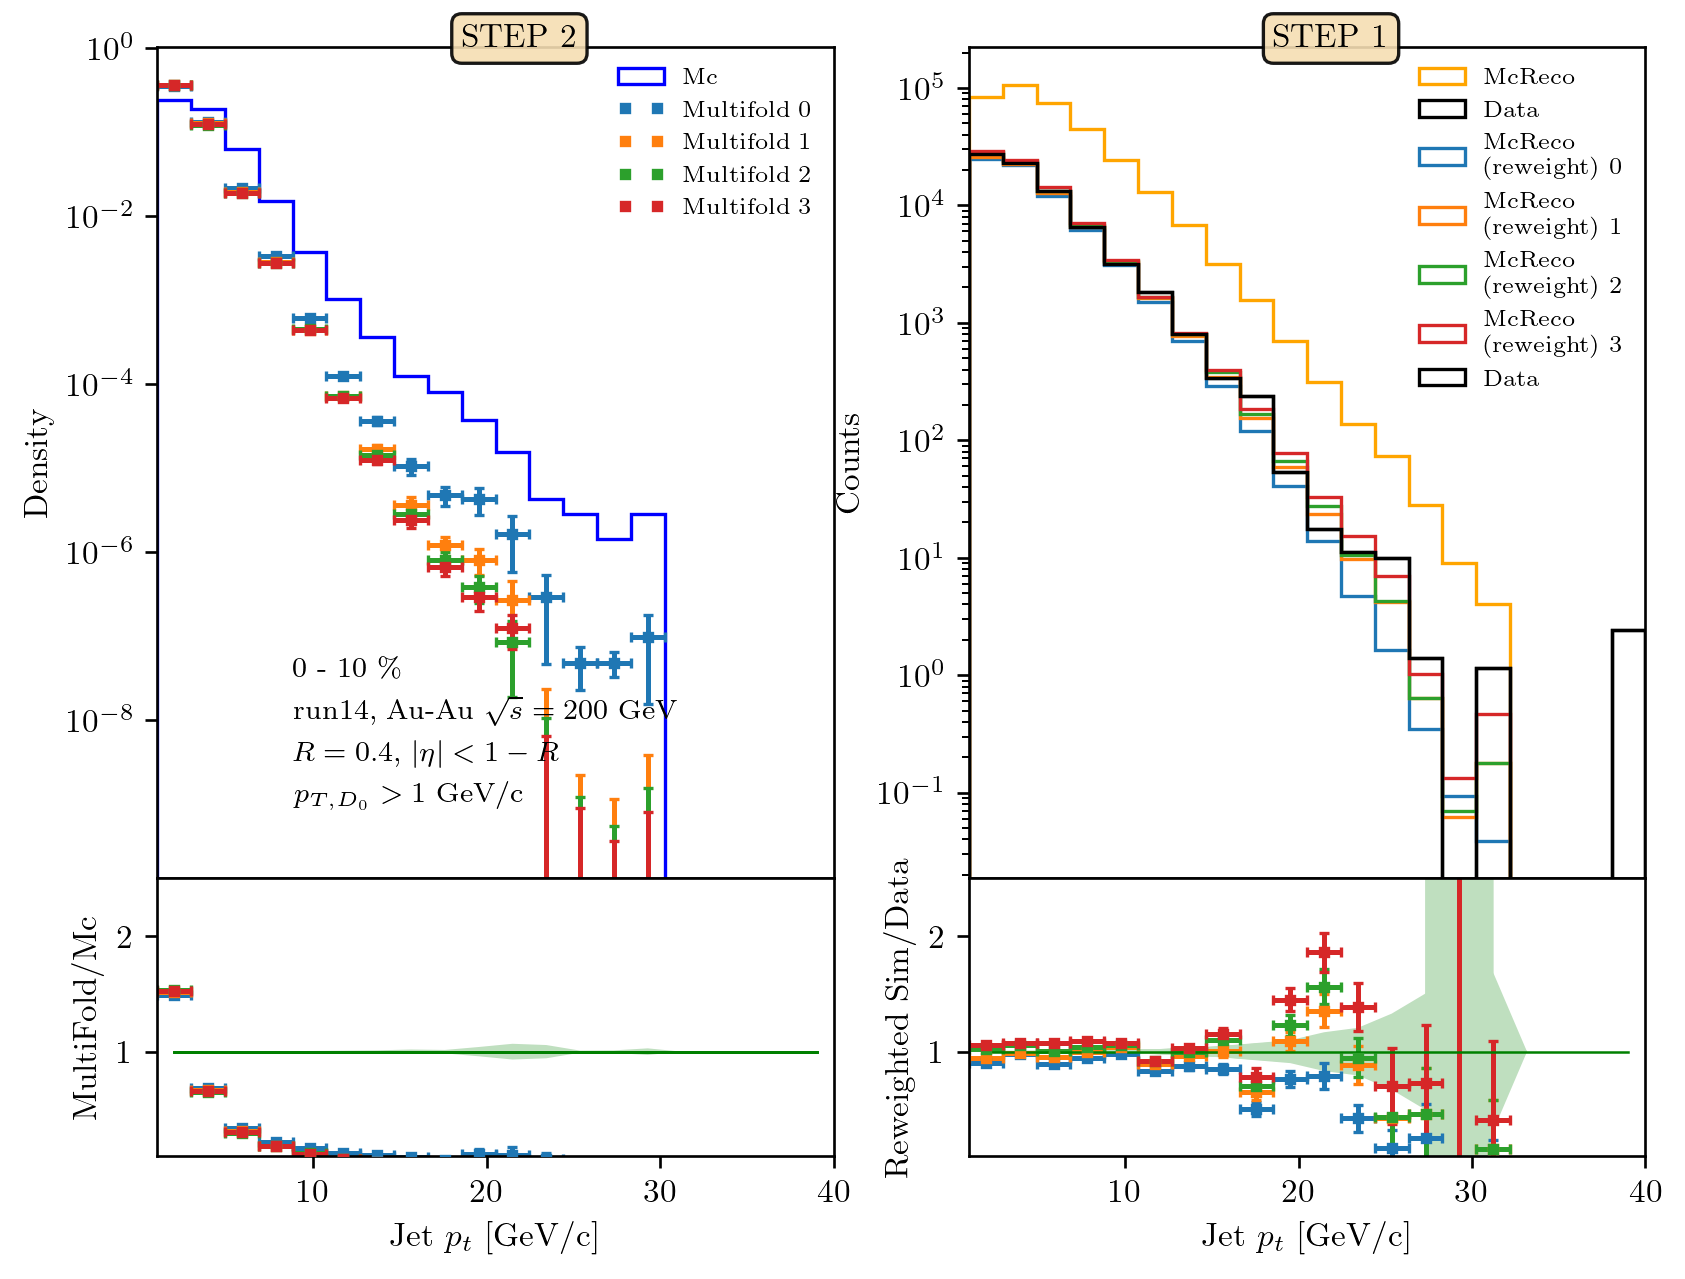

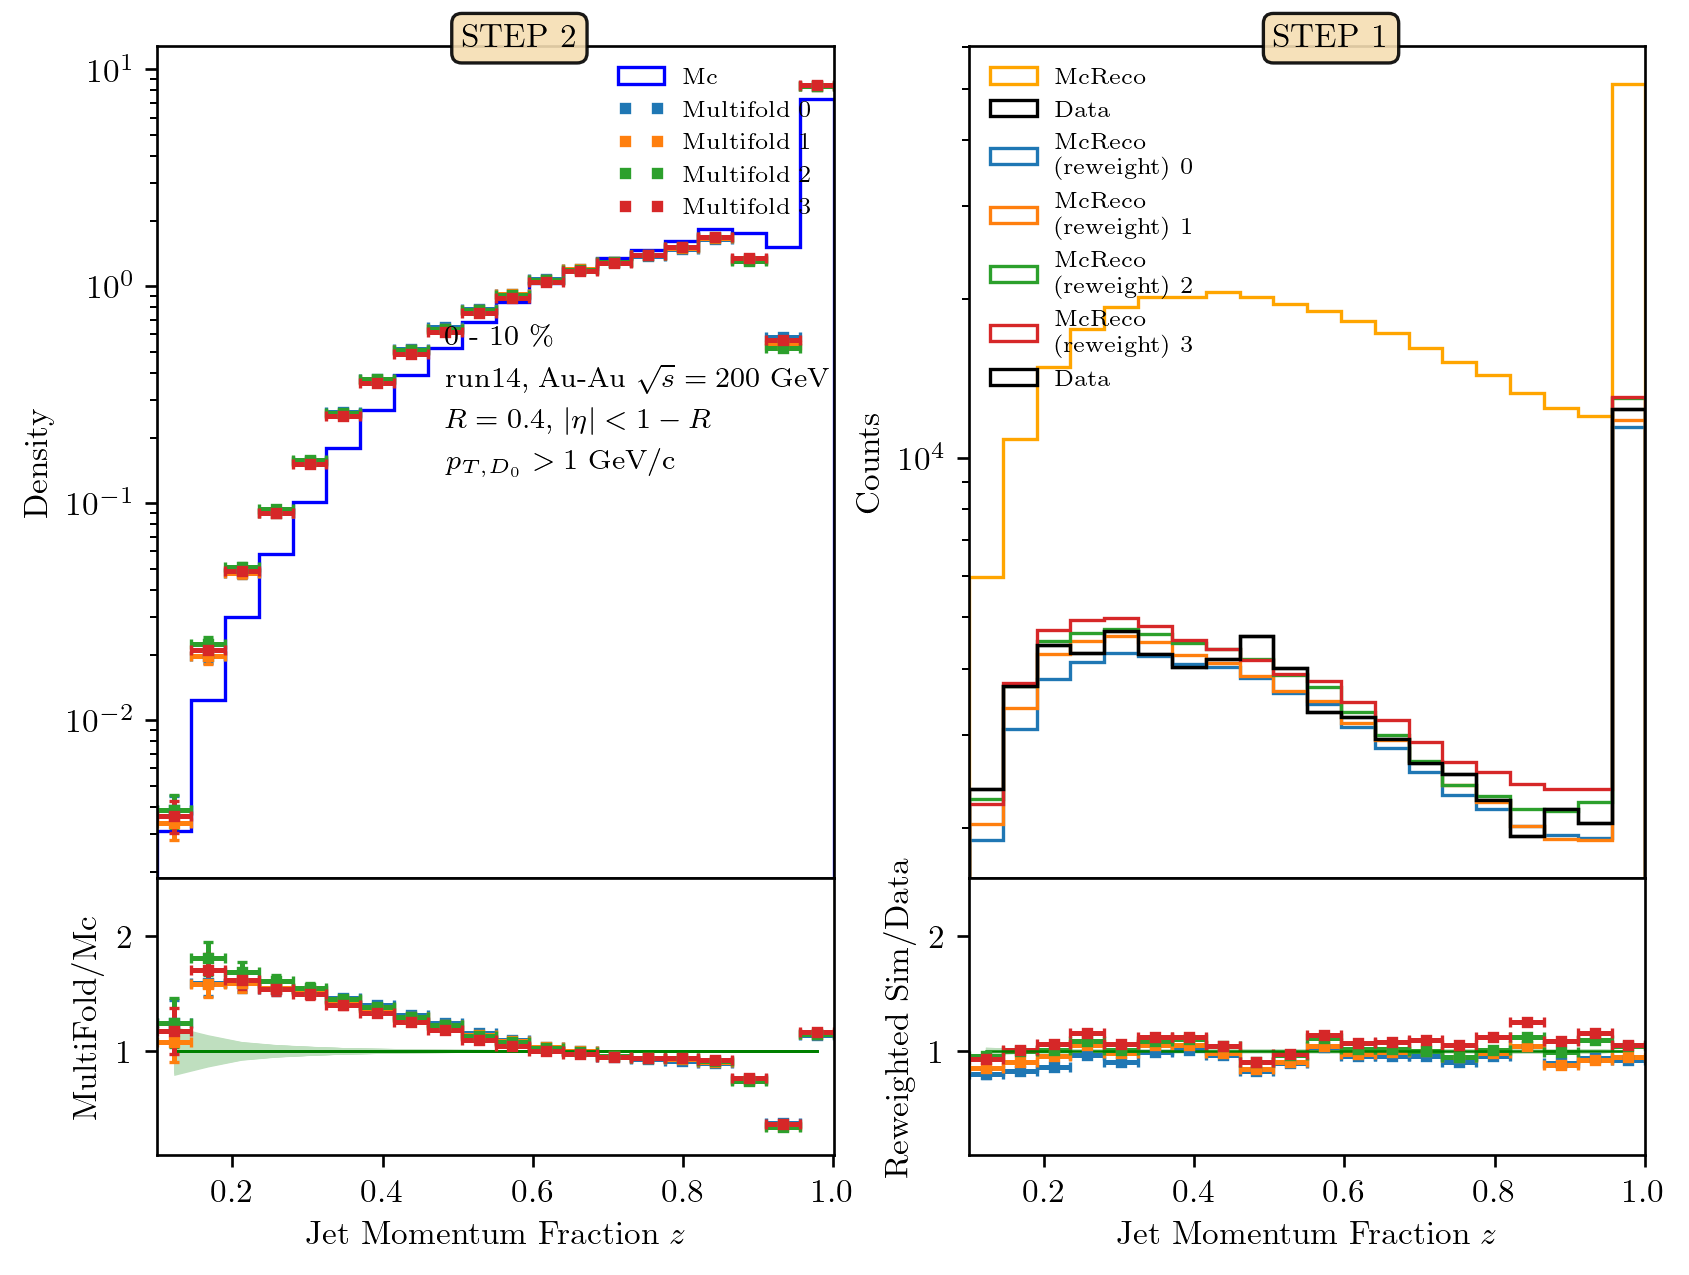

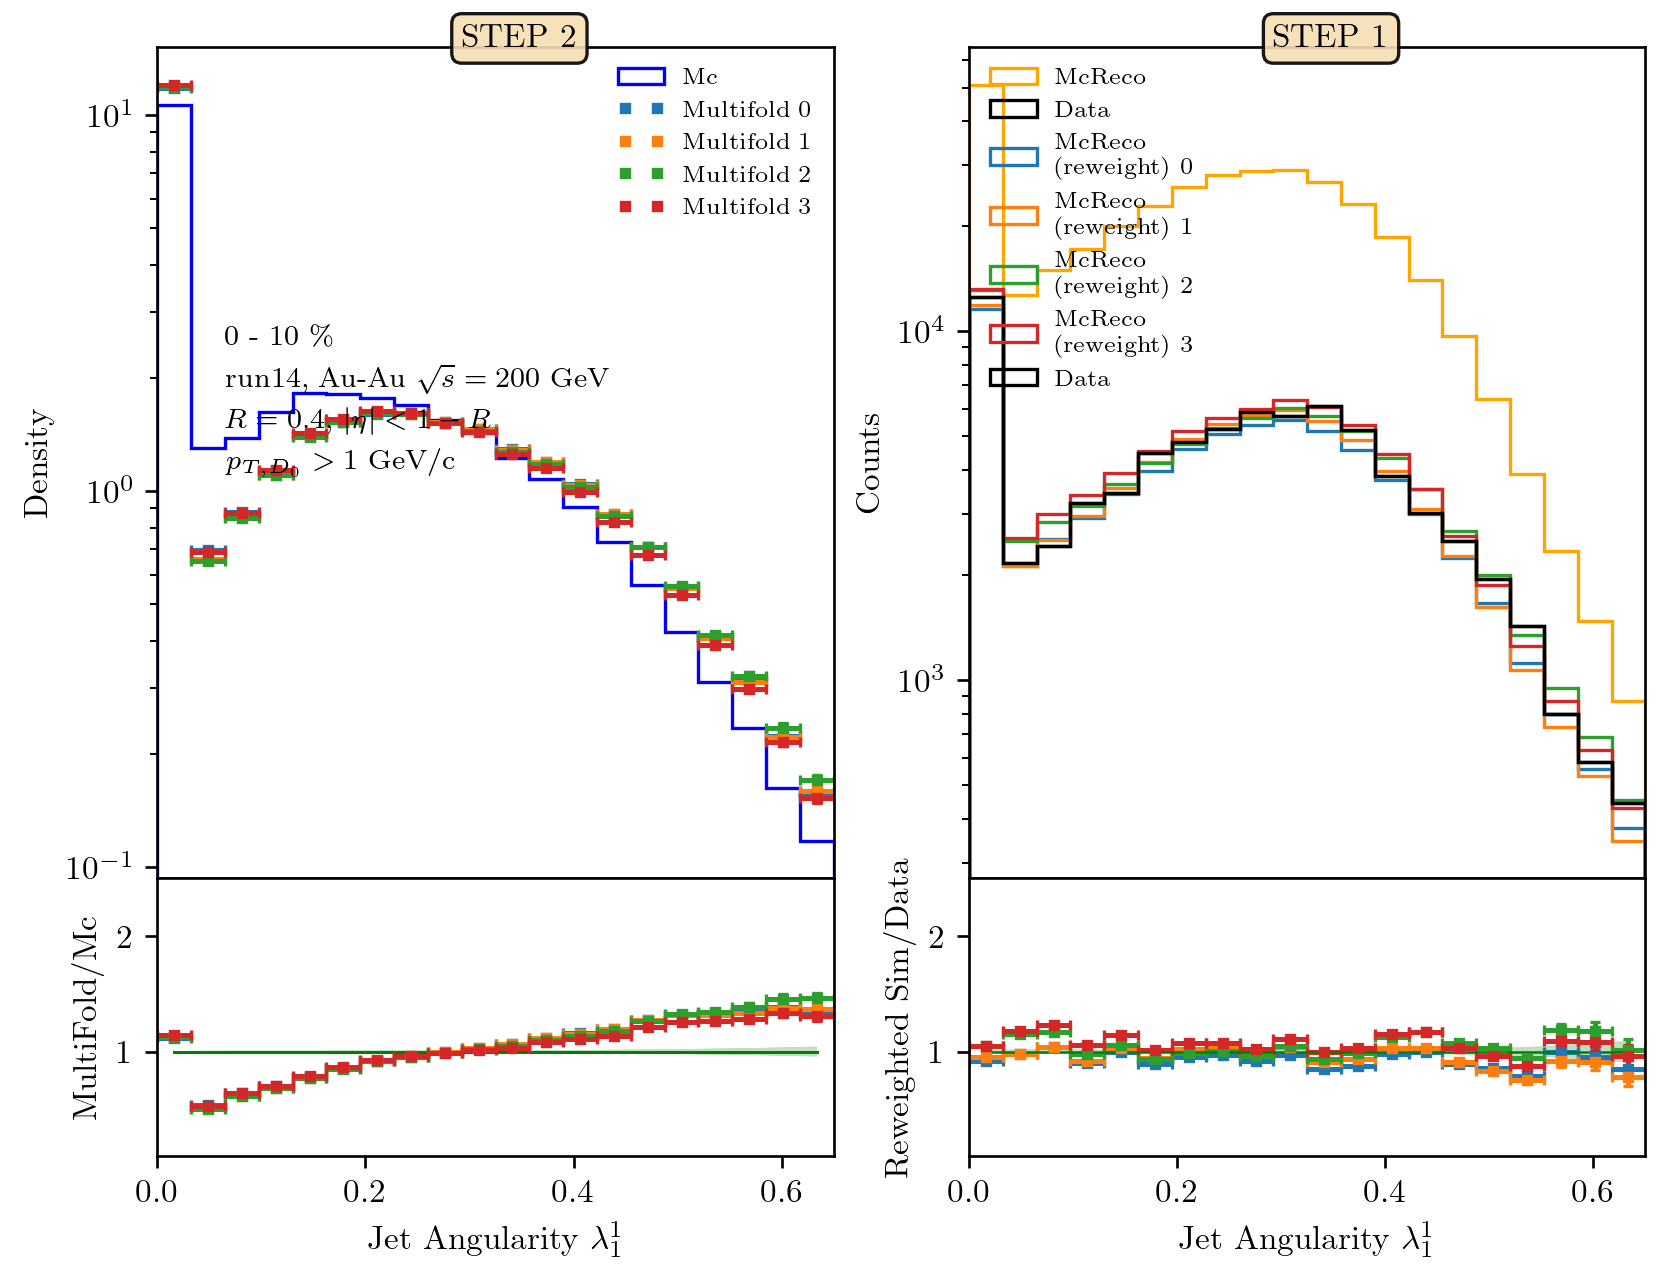

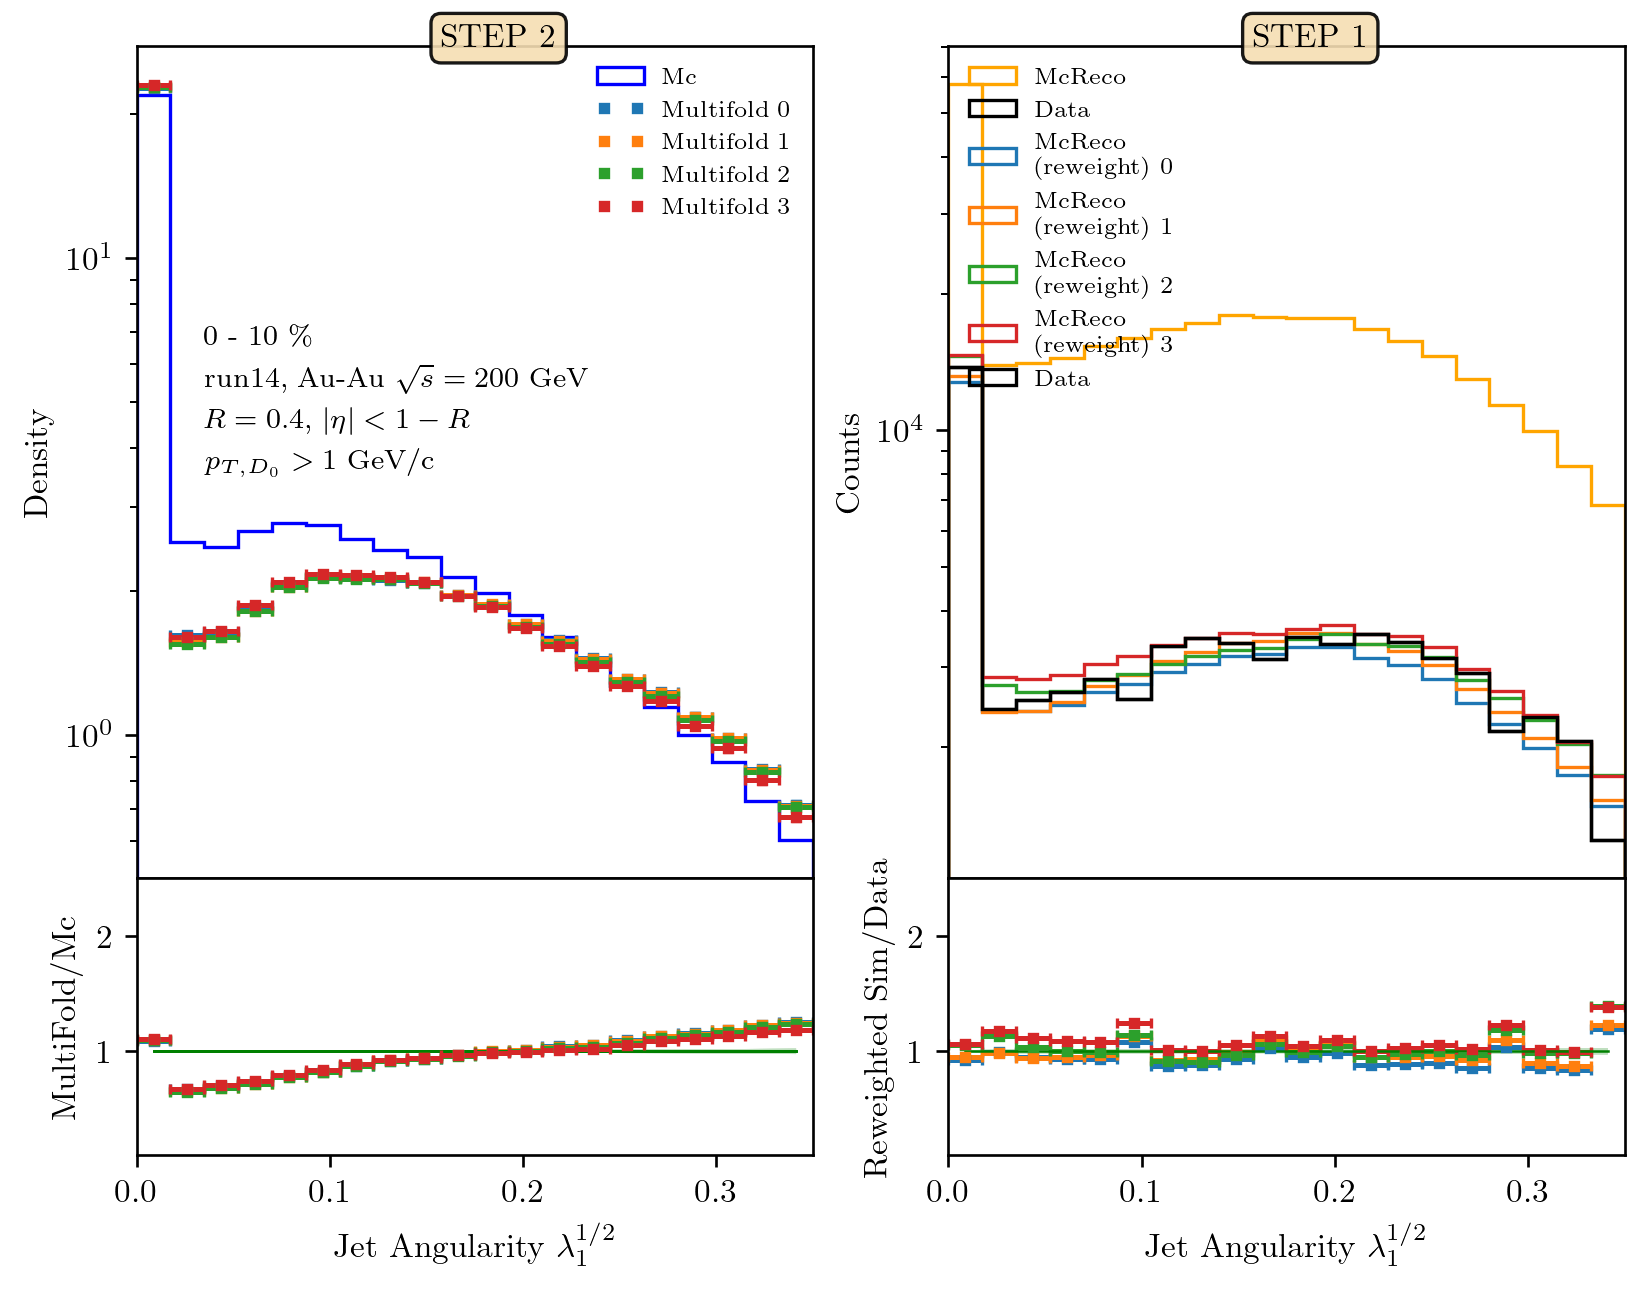

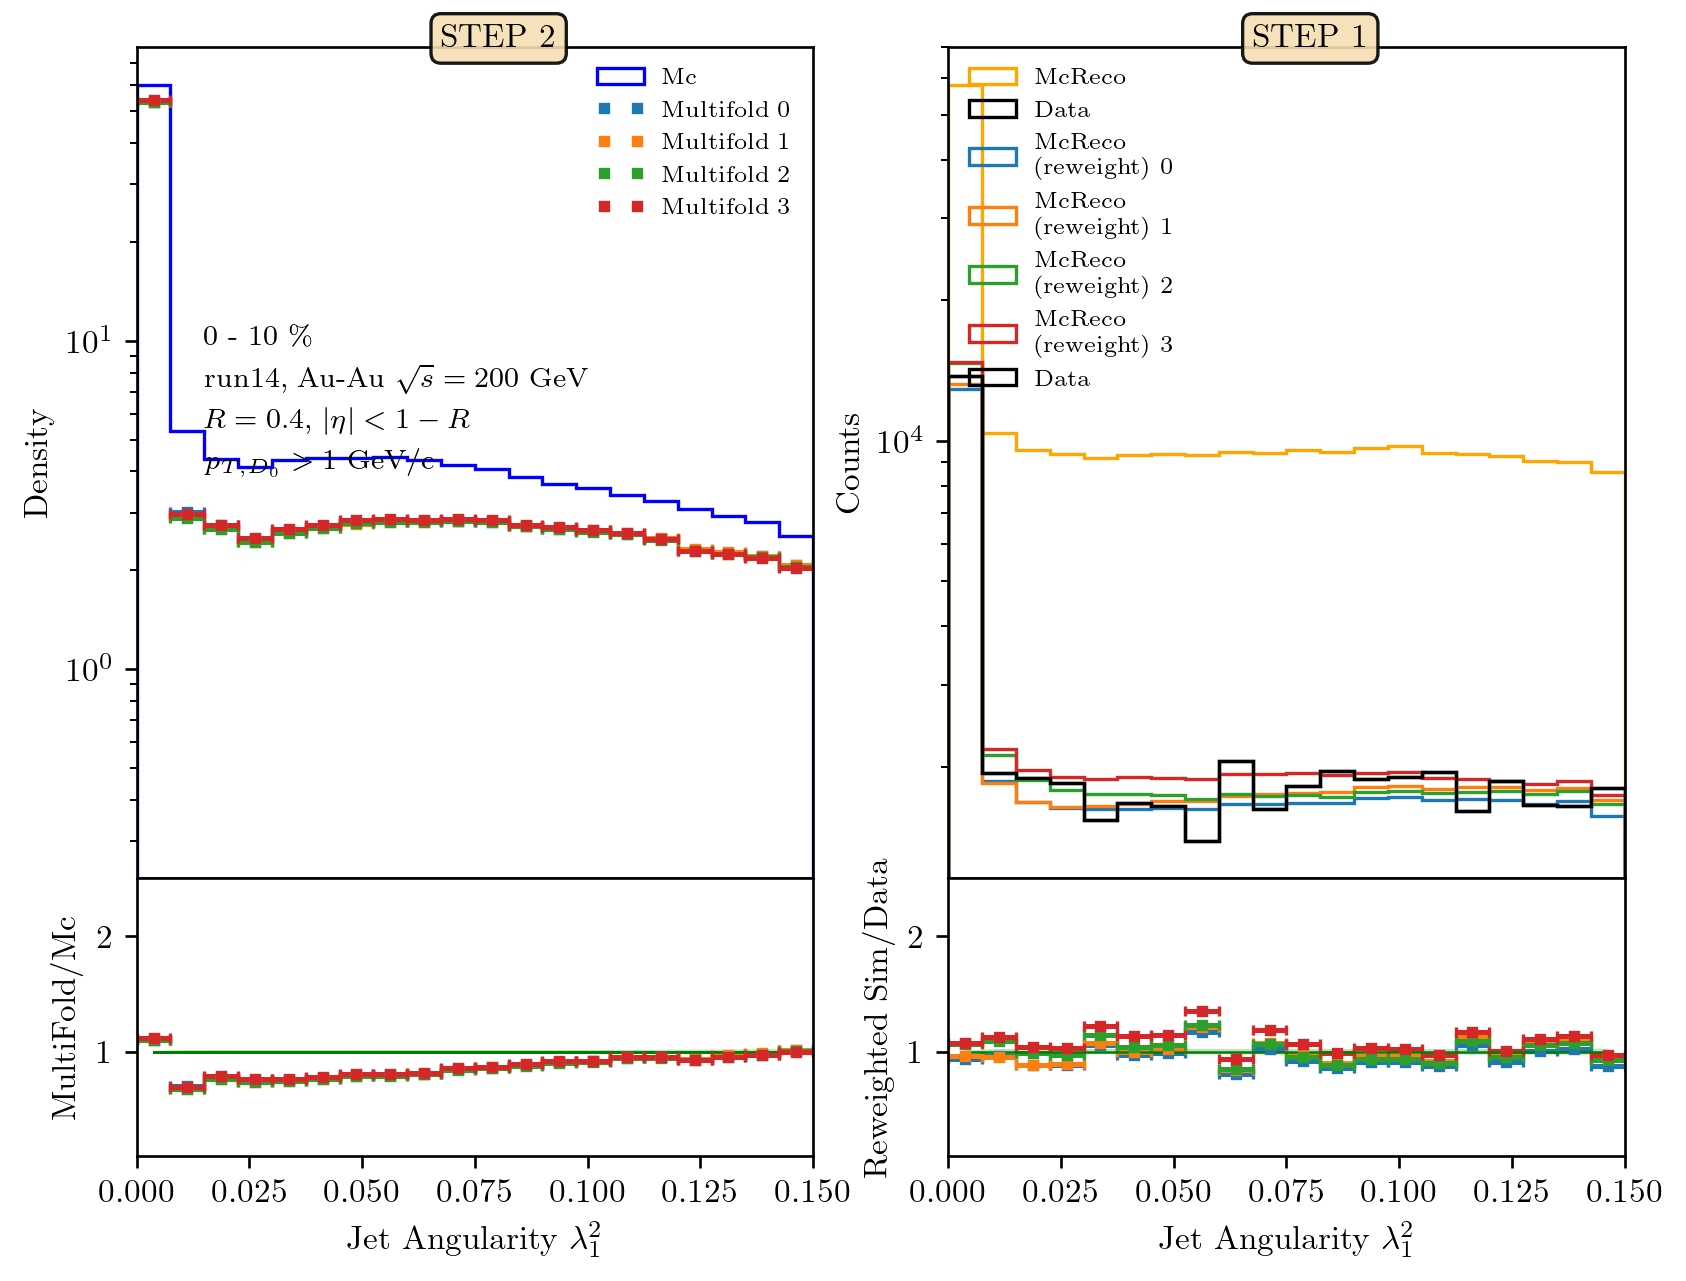

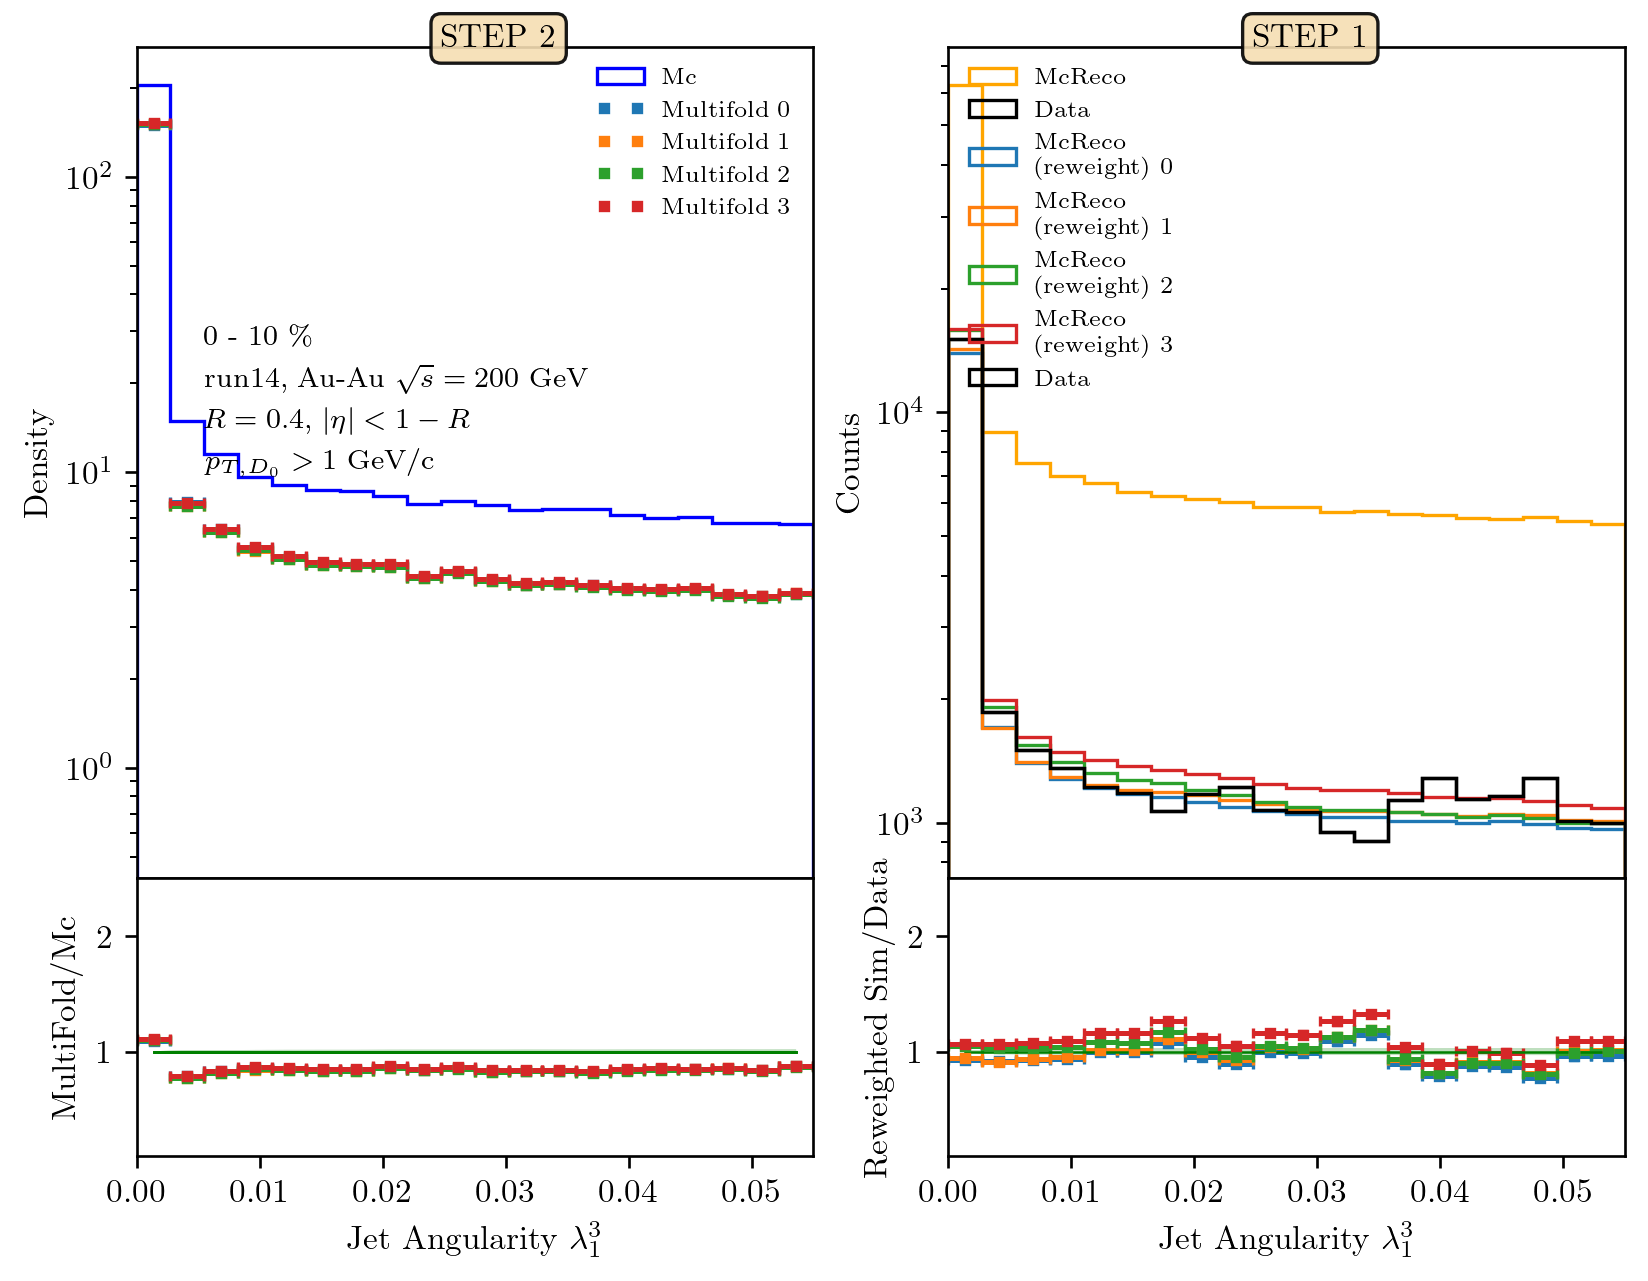

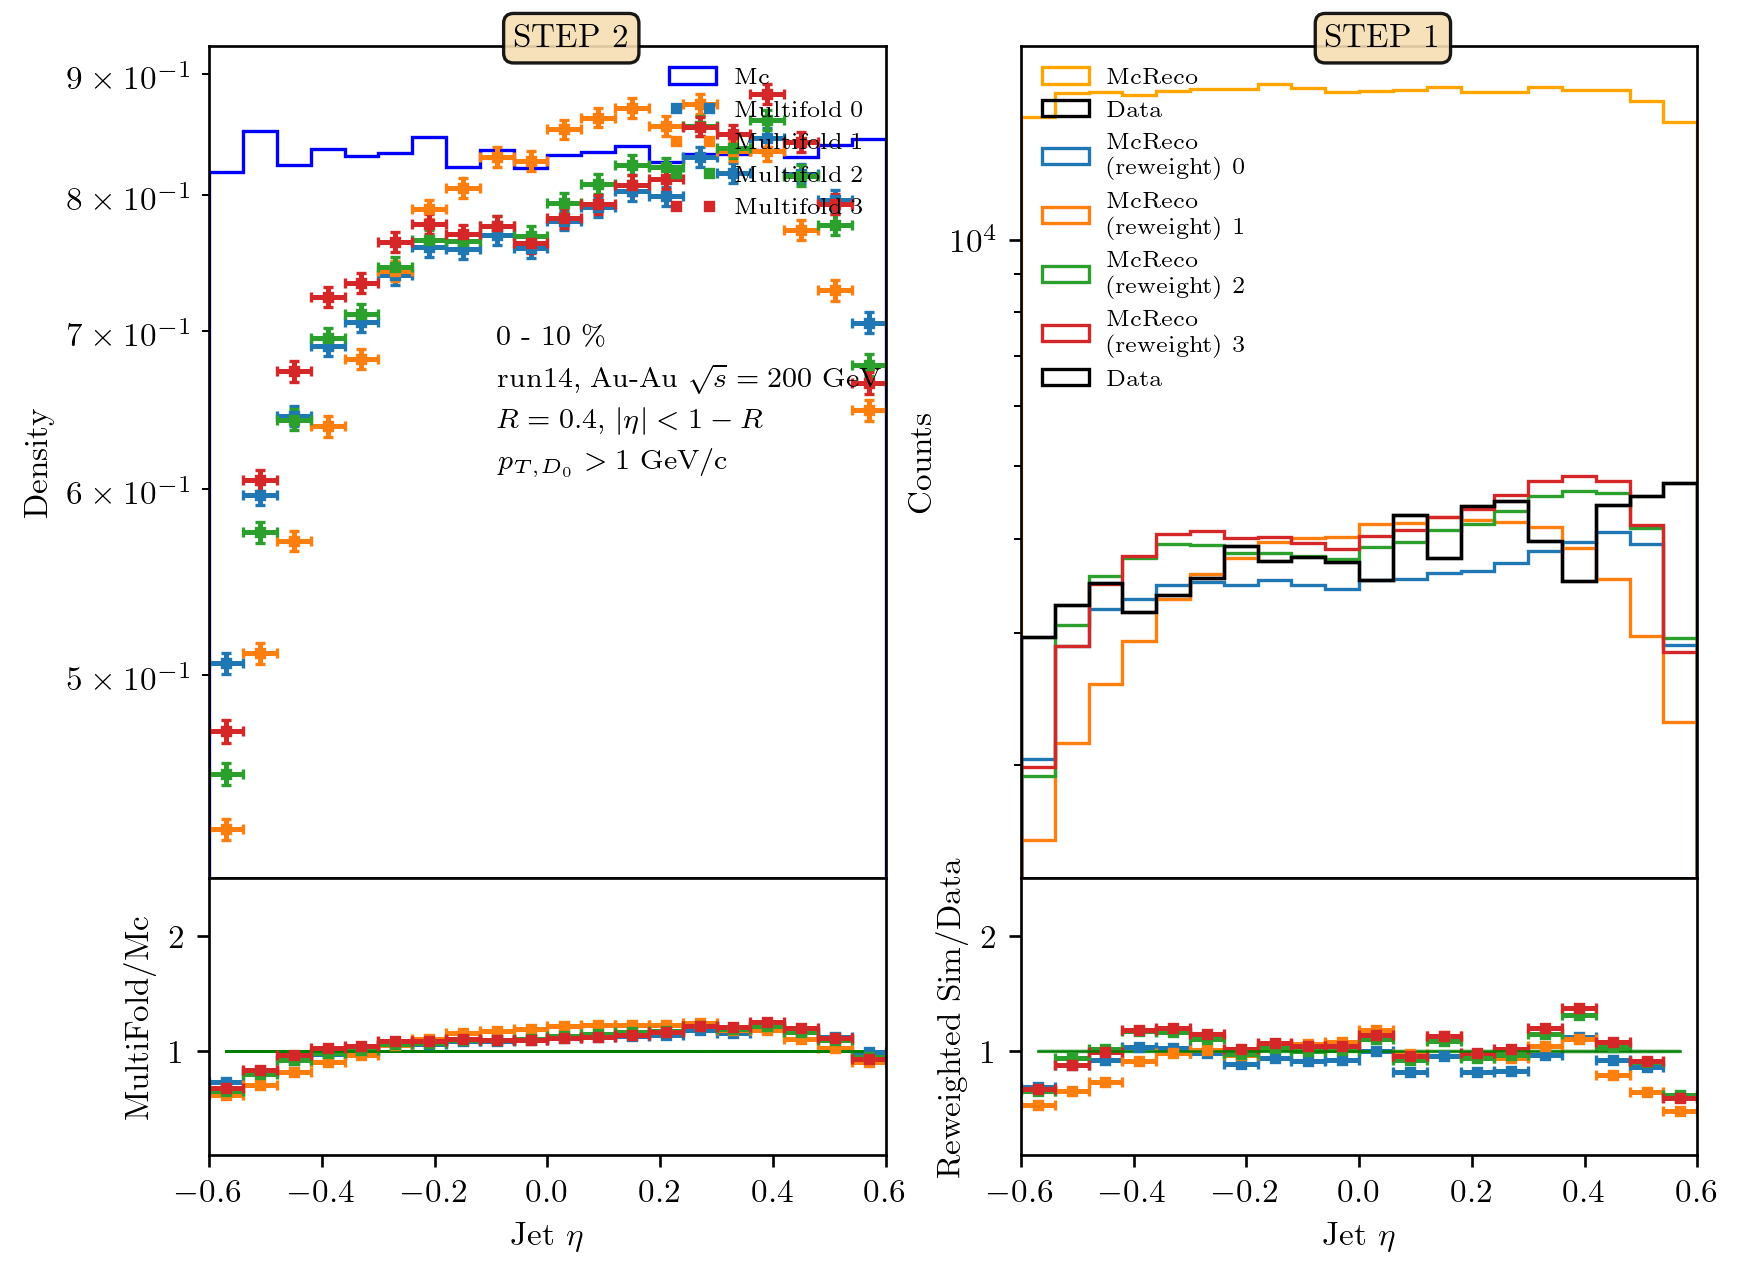

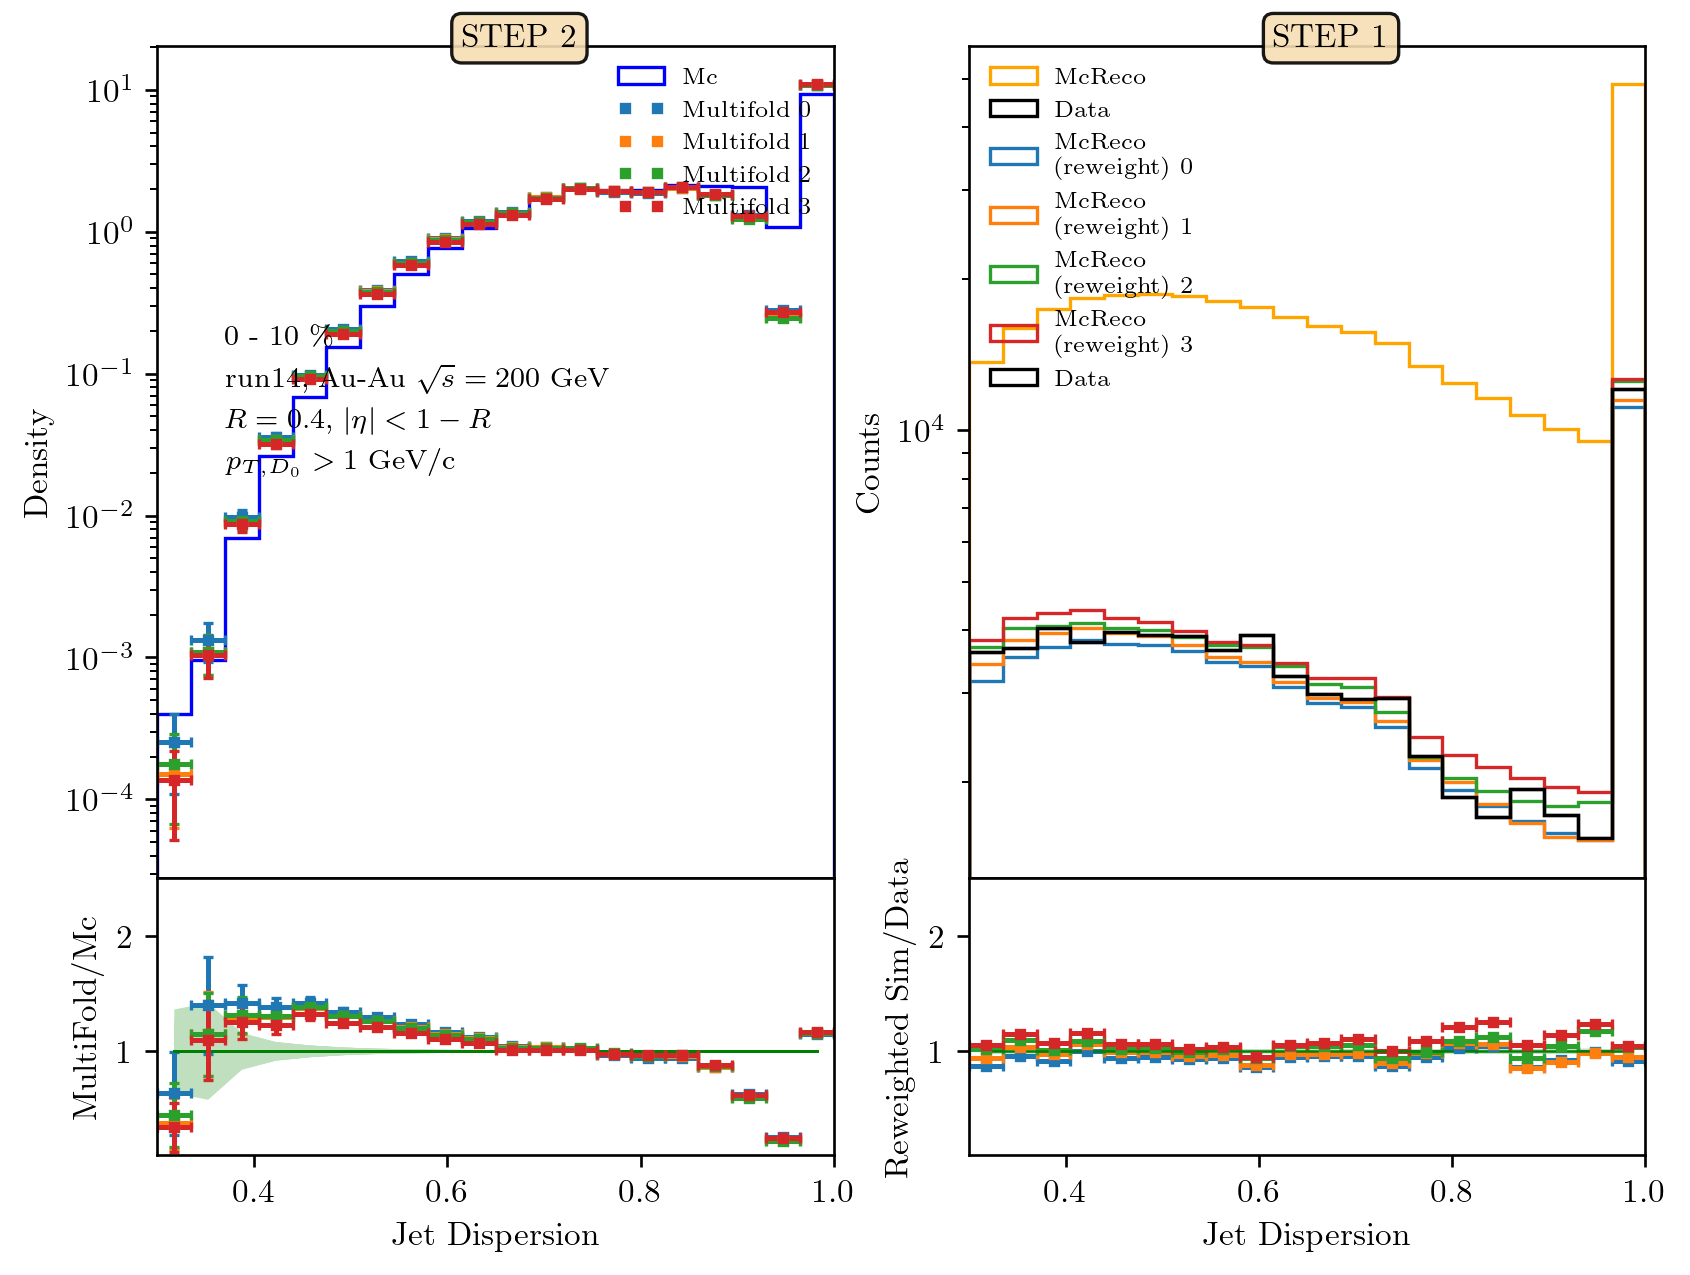

In [14]:
iteration_nice_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']

for ob_i,(obkey,ob) in enumerate(obs.items()):
    fig = plt.figure(figsize=(8,6))
    gs = fig.add_gridspec(2, 2, hspace=0,height_ratios=[3, 1] )
    axs= gs.subplots()
    mcAxis = axs[0,0]
    recoAxis = axs[0,1]
    ratioMcAxis = axs[1,0]
    ratioRecoAxis = axs[1,1]
    # set invisible x axis of mcAxis and recoAxis
    mcAxis.xaxis.set_visible(False)
    recoAxis.xaxis.set_visible(False)
    mcAxis.set_yscale('log')
    recoAxis.set_yscale('log')
    # set x and y limits
    mcAxis.set_xlim(ob['xlim'])
    recoAxis.set_xlim(ob['xlim_det'])
    ratioMcAxis.set_xlim(ob['xlim'])
    ratioRecoAxis.set_xlim(ob['xlim_det'])
    # mcAxis.set_ylim(ob['ylim'])
    

    if isClosureTest:
        ratioMcAxis.set_ylim(0.75, 1.25)
        ratioRecoAxis.set_ylim(0.75, 1.25)
    else:
        ratioMcAxis.set_ylim(0.1, 2.5)
        ratioRecoAxis.set_ylim(0.1, 2.5)


    # set titles for axis
    ratioMcAxis.set_xlabel(ob['xlabel'])
    ratioMcAxis.set_ylabel('MultiFold/Mc')
    mcAxis.set_ylabel('Counts')
    ratioRecoAxis.set_xlabel(ob['xlabel'])
    ratioRecoAxis.set_ylabel('Reweighted Sim/Data')
    recoAxis.set_ylabel(ob['ylabel'])

    # Plot the Unfolded Distributions of the Observable
    settingDensity = False
    # if not isClosureTest:
    settingDensity = True
    mcAxis.set_ylabel('Density')  

    mcAxis.hist(trainGen[obkey], bins=ob['bins_mc'], color='blue', label='Mc', **hist_style, density=settingDensity)
    mcHist, mcHist_unc = modplot.calc_hist(trainGen[obkey], bins=ob['bins_mc'], density=settingDensity)[:2]

    for it in range(iterations):
        unfolded, unfolded_unc = modplot.calc_hist(trainGen[obkey], weights=weights[it,1,:], bins=ob['bins_mc'], density=settingDensity)[:2]
        mcAxis.plot(ob['midbins_mc'], unfolded, **omnifold_style, label= f'Multifold {it}', color=iteration_nice_colors[it])
        mcAxis.errorbar(ob['midbins_mc'], unfolded, xerr=ob['binwidth_mc']/2, yerr=unfolded_unc, 
                                            color=iteration_nice_colors[it], **modplot.style('errorbar'))
    
        # Plot the Ratios of the OmniFold distribution to truth (with statistical uncertainties)
        mc_ratio = unfolded/(mcHist+ 10**-50)
        ratioMcAxis.plot(ob['midbins_mc'], mc_ratio,**omnifold_style)
        ratioMcAxis.plot([np.min(ob['midbins_mc']), np.max(ob['midbins_mc'])], [1, 1], '-', color='green', lw=0.75)

        # ratio uncertainties
        mc_ratio_unc = unfolded_unc/(mcHist + 10**-50)
        ratioMcAxis.fill_between(ob['midbins_mc'], 1 - mc_ratio_unc, 1 + mc_ratio_unc,
                        facecolor=truth_style['facecolor'], zorder=-2)
        ratioMcAxis.errorbar(ob['midbins_mc'], mc_ratio, xerr=ob['binwidth_mc']/2, yerr=mc_ratio_unc,
                                                color=iteration_nice_colors[it], **modplot.style('errorbar'))
    

 # ///////////////////////////////////////////////////
    

   # plot the "sim" histogram of the observable
    recoAxis.hist(trainReco[obkey], bins=ob['bins_det'], color='orange', label='McReco', **hist_style)
    recoHist, edges, _ = recoAxis.hist(testReco[obkey], bins=ob['bins_det'], color='black', label='Data', weights =testWts, **hist_style)

    # plot the "sim" histogram of the observable
    for it in range(iterations):
        reweightedSim, edges, _ = recoAxis.hist(trainReco[obkey], bins=ob['bins_det'], color= iteration_nice_colors[it], weights=weights[it, 0,:], label='McReco\n(reweight) {}'.format(it), **hist_style)
        bin_centers = 0.5 * (edges[:-1] + edges[1:])
    # recoAxis.errorbar(bin_centers, reweightedSim, yerr=np.sqrt(entries), color='brown', fmt='',linestyle='')

   # Plot the Ratios of the Scaled Sim to Data (with statistical uncertainties)
        reco_ratio = reweightedSim/(recoHist+ 10**-50)
        ratioRecoAxis.plot(bin_centers, reco_ratio, **omnifold_style, color=iteration_nice_colors[it])

    # ratio uncertainties
        reco_ratio_unc = np.sqrt(reweightedSim)/(ob['data_hist'] + 10**-50)
        ratioRecoAxis.fill_between(bin_centers, 1 - reco_ratio_unc, 1 + reco_ratio_unc,
                        facecolor=truth_style['facecolor'], zorder=-2)
        ratioRecoAxis.errorbar(bin_centers, reco_ratio, xerr=ob['binwidth_det']/2, yerr=reco_ratio_unc, 
                                            color=iteration_nice_colors[it], **modplot.style('errorbar'))
 
    ratioRecoAxis.plot([np.min(bin_centers), np.max(bin_centers)], [1, 1], '-', color='green', lw=0.75)
        # plot the "data" histogram of the observable
    recoHist, edges, _ = recoAxis.hist(testReco[obkey], bins=ob['bins_det'], color='black', label='Data', weights =testWts, **hist_style)

    # legend style and ordering
    loc = ob.get('legend_loc', 'upper right')
    modplot.legend( ax=mcAxis, frameon=False,  loc=loc, fontsize = 7)
    loc = ob.get('legend_loc', 'upper left')
    modplot.legend( ax=recoAxis, frameon=False,  loc=loc, fontsize = 7)

    # stamp to put on the plots
    modplot.stamp(*ob['stamp_xy'], delta_y=0.05, ax=mcAxis,
    # centrality label
                 line_0=r'{} - {} \%'.format(centralityBins[0], centralityBins[1]), 
                 line_1=r'run14, Au-Au $\sqrt{s}=200$ GeV',
                 line_2=r'$R=0.4$, $|\eta|<1-R$',
                 line_3=r'$p_{T,D_0}>1$ GeV/c')


    # place a text box in upper left in axes coords

    if isClosureTest:
        mcAxis.text(0.65, 0.7, 'Closure Test',  transform=mcAxis.transAxes, bbox=dict(boxstyle='round', facecolor='turquoise', alpha=0.5, pad= 1))
    mcAxis.text(0.45, 1., 'STEP 2',  transform=mcAxis.transAxes, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9))
    recoAxis.text(0.45, 1., 'STEP 1',  transform=recoAxis.transAxes, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9))
    # recoAxis.text(0.28, 0.1, 'HI Background subtracted',  transform=recoAxis.transAxes, bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.2))

        # # save plot (by default in the same directory as this notebook).
    fig.savefig(f"{saveFolder}/omnifold_{obkey}.pdf", bbox_inches='tight')
    plt.show()


In [ ]:
# convert to ROOT histograms and save
import ROOT
from ROOT import TH1D, TFile

# create a ROOT file to save the histograms
root_file = TFile(f"{saveFolder}/unfolded_histograms.root", "RECREATE")
